In [81]:
!pip install missingno

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno  # Eksik veri görselleştirmesi için
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import ElasticNet, SGDRegressor
from sklearn.mixture import GaussianMixture
import warnings

# uyarıları ve ayarları düzenliyorum
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)

# görselleştirme tema ayarları
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Kütüphaneler başarıyla yüklendi ve konfigürasyon tamamlandı.")

Kütüphaneler başarıyla yüklendi ve konfigürasyon tamamlandı.


Veri Seti Boyutu: (30000, 17)


<Figure size 1400x600 with 0 Axes>

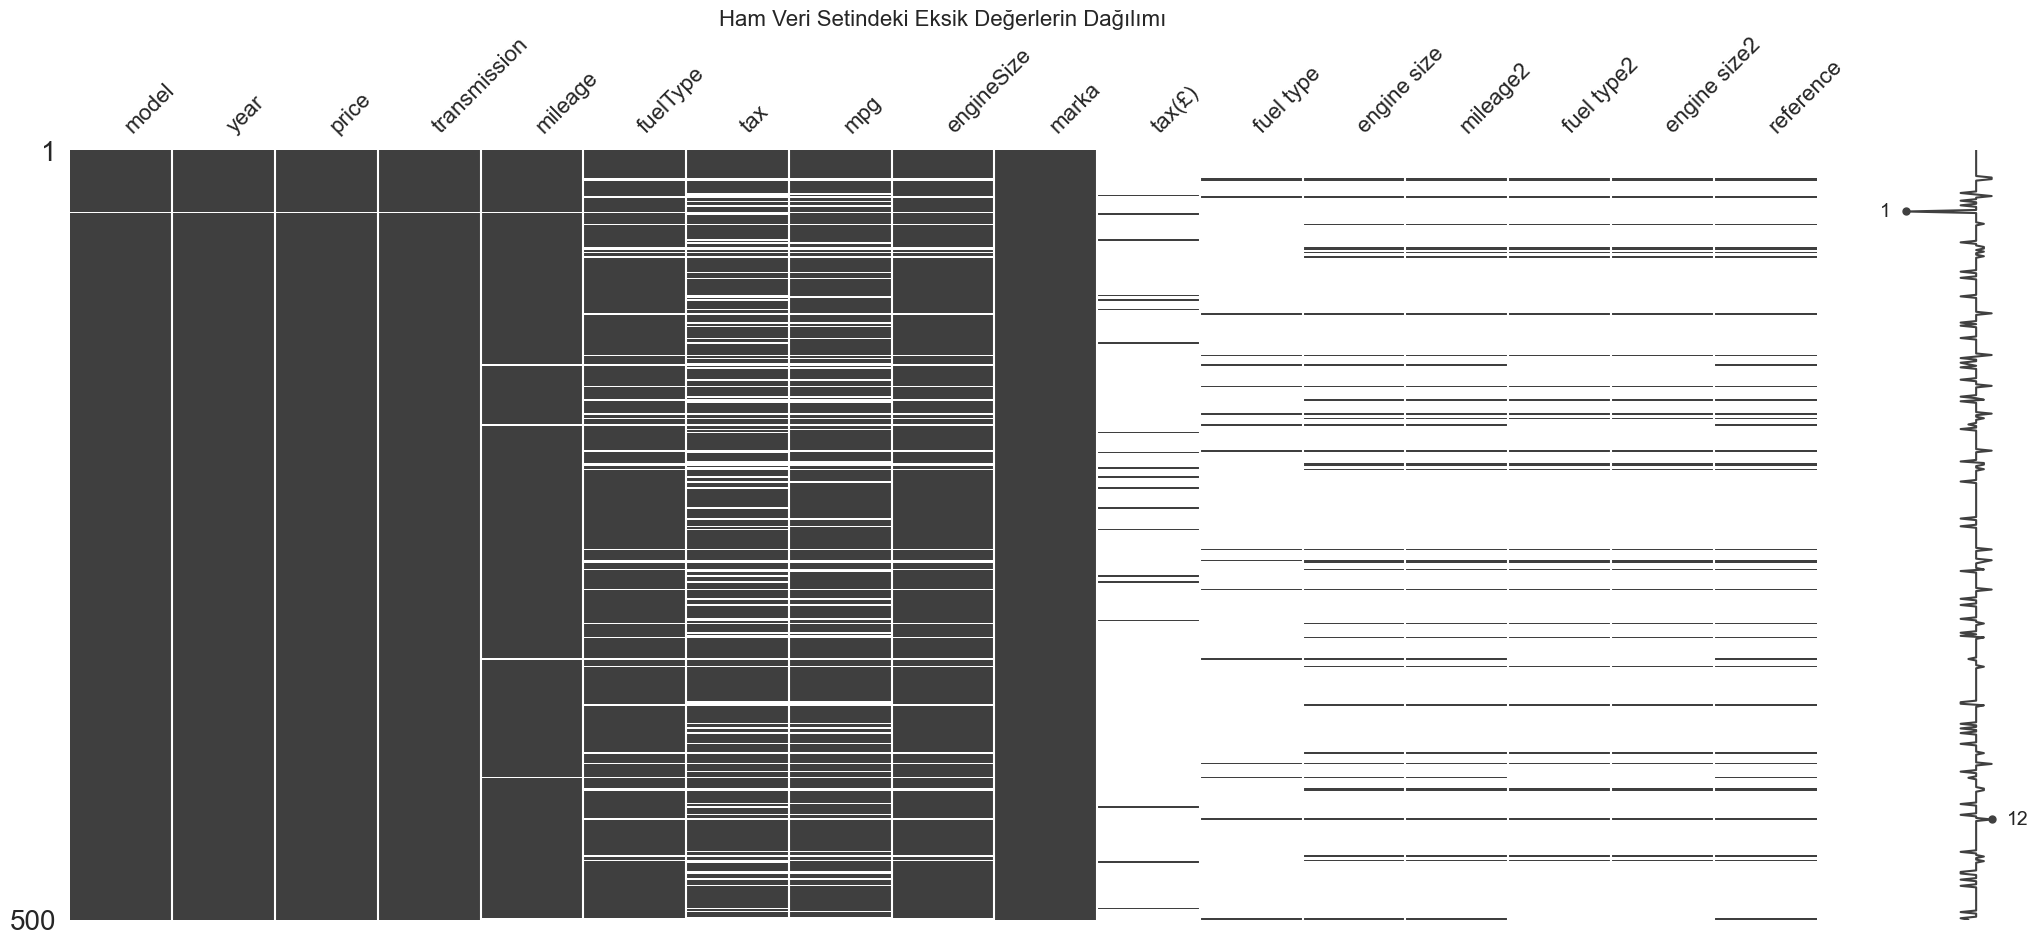

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,marka,tax(£),fuel type,engine size,mileage2,fuel type2,engine size2,reference
0,Kamiq,2019.00,21990,Semi-Auto,563,Diesel,145.00,52.30,1.60,skoda,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Q5,2016.00,20498,Semi-Auto,33657,Diesel,200.00,47.10,2.00,audi,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Touareg,2019.00,39995,Semi-Auto,7000,Diesel,145.00,34.50,3.00,vw,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Aygo,2019.00,8690,Manual,2438,Petrol,145.00,56.50,1.00,toyota,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,S-MAX,2020.00,34498,Semi-Auto,4623,Diesel,145.00,43.50,2.00,ford,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         29965 non-null  object 
 1   year          29946 non-null  float64
 2   price         29965 non-null  object 
 3   transmission  29965 non-null  object 
 4   mileage       29735 non-null  object 
 5   fuelType      27520 non-null  object 
 6   tax           23967 non-null  float64
 7   mpg           25191 non-null  float64
 8   engineSize    27520 non-null  float64
 9   marka         30000 non-null  object 
 10  tax(£)        1224 non-null   float64
 11  fuel type     894 non-null    object 
 12  engine size   2414 non-null   object 
 13  mileage2      2428 non-null   object 
 14  fuel type2    2215 non-null   object 
 15  engine size2  2215 non-null   object 
 16  reference     2445 non-null   object 
dtypes: float64(5), object(12)
memory usage: 3.9+ MB


None

In [83]:
# veri setini yüklüyorum
try:
    df = pd.read_csv('ekip_odevi_ham_veri_30k.csv', on_bad_lines='skip')
    print(f"Veri Seti Boyutu: {df.shape}")
except Exception as e:
    print(f"Hata: {e}")

# eksik verilerin görselleştirilmesi (Matrix Plot)
plt.figure(figsize=(14, 6))
msno.matrix(df.sample(500)) # 500 örneklem ile hızlı bakış
plt.title('Ham Veri Setindeki Eksik Değerlerin Dağılımı', fontsize=16)
plt.show()

# veri tipleri ve örneklem
display(df.head())
display(df.info())

In [84]:
# veri temizleme fonksiyonu oluşturuyorum
def clean_and_coalesce(dataframe):
    df_proc = dataframe.copy()
    
    # vergi (Tax) Birleştirme
    if 'tax(£)' in df_proc.columns:
        df_proc['tax'] = df_proc['tax'].fillna(df_proc['tax(£)'])
        
    # yakıt ve Motor Hacmi Birleştirme
    fill_maps = {
        'fuelType': ['fuel type', 'fuel type2'],
        'engineSize': ['engine size', 'engine size2'],
        'mileage': ['mileage2']
    }
    
    for target, sources in fill_maps.items():
        for source in sources:
            if source in df_proc.columns:
                df_proc[target] = df_proc[target].fillna(df_proc[source])
                
    # temiz sütunların seçilmesi
    main_cols = ['model', 'year', 'price', 'transmission', 'mileage', 'fuelType', 'tax', 'mpg', 'engineSize']
    df_clean = df_proc[main_cols].copy()
    
    # string karakter temizliği (£, virgül vb.)
    for col in ['price', 'mileage', 'tax', 'mpg', 'engineSize']:
        if df_clean[col].dtype == 'object':
            df_clean[col] = df_clean[col].astype(str).str.replace(r'[£,]', '', regex=True)
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
            
    # kritik eksik verilerin ve tekrarların atılması
    original_len = len(df_clean)
    df_clean.dropna(subset=['price', 'year', 'model'], inplace=True)
    df_clean.drop_duplicates(inplace=True)
    
    print(f"Temizlik Öncesi Satır: {original_len} -> Sonrası: {len(df_clean)}")
    return df_clean

df_clean = clean_and_coalesce(df)

Temizlik Öncesi Satır: 30000 -> Sonrası: 29489


In [85]:
# ÖZELLİK MÜHENDİSLİĞİ (FEATURE ENGINEERING)

current_year = 2024
df_clean['car_age'] = current_year - df_clean['year']
# 0 yaşındaki araçları hatayı önlemek için 1 kabul edebiliriz veya 0 bırakabiliriz. 
df_clean['car_age'] = df_clean['car_age'].apply(lambda x: 0 if x < 0 else x) 

# yıllık ortalama kullanım
# 0'a bölme hatasından kaçınmak için yaş 0 ise 1 alıyorum
df_clean['km_per_year'] = df_clean['mileage'] / df_clean['car_age'].replace(0, 1)

# mantıksız veri filtresi
df_clean = df_clean[df_clean['engineSize'] > 0]
df_clean = df_clean[df_clean['price'] > 500] # Hurda araçları eleme

print("Yeni özellikler eklendi: 'car_age', 'km_per_year'")

Yeni özellikler eklendi: 'car_age', 'km_per_year'


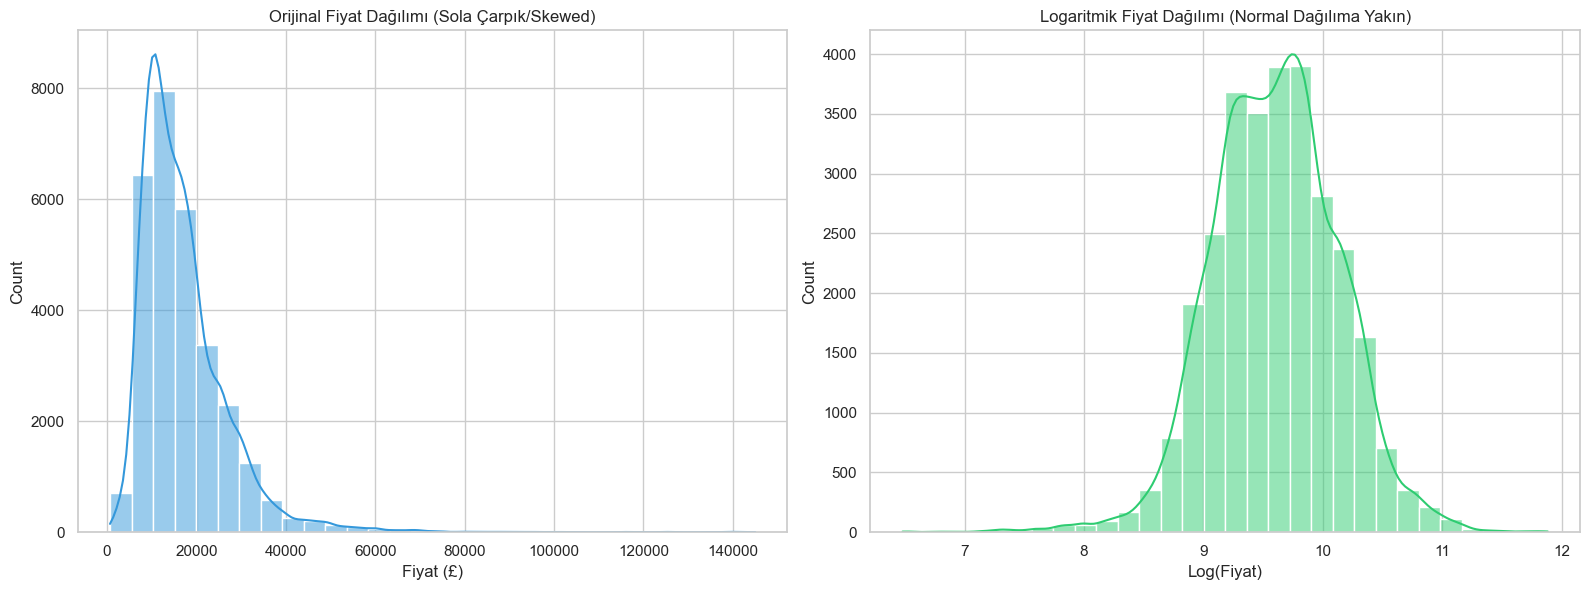

Yorum: Orijinal fiyat verisi dengesiz dağıldığı için regresyon modellerinde Log-Transform kullanmak başarıyı artıracaktır.


In [86]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# orijinal fiyat dağılımına bakıyorum
sns.histplot(df_clean['price'], kde=True, ax=ax[0], color='#3498db', bins=30)
ax[0].set_title('Orijinal Fiyat Dağılımı (Sola Çarpık/Skewed)', fontsize=12)
ax[0].set_xlabel('Fiyat (£)')

# log-transform fiyat dağılımı
sns.histplot(np.log1p(df_clean['price']), kde=True, ax=ax[1], color='#2ecc71', bins=30)
ax[1].set_title('Logaritmik Fiyat Dağılımı (Normal Dağılıma Yakın)', fontsize=12)
ax[1].set_xlabel('Log(Fiyat)')

plt.tight_layout()
plt.show()

print("Yorum: Orijinal fiyat verisi dengesiz dağıldığı için regresyon modellerinde Log-Transform kullanmak başarıyı artıracaktır.")

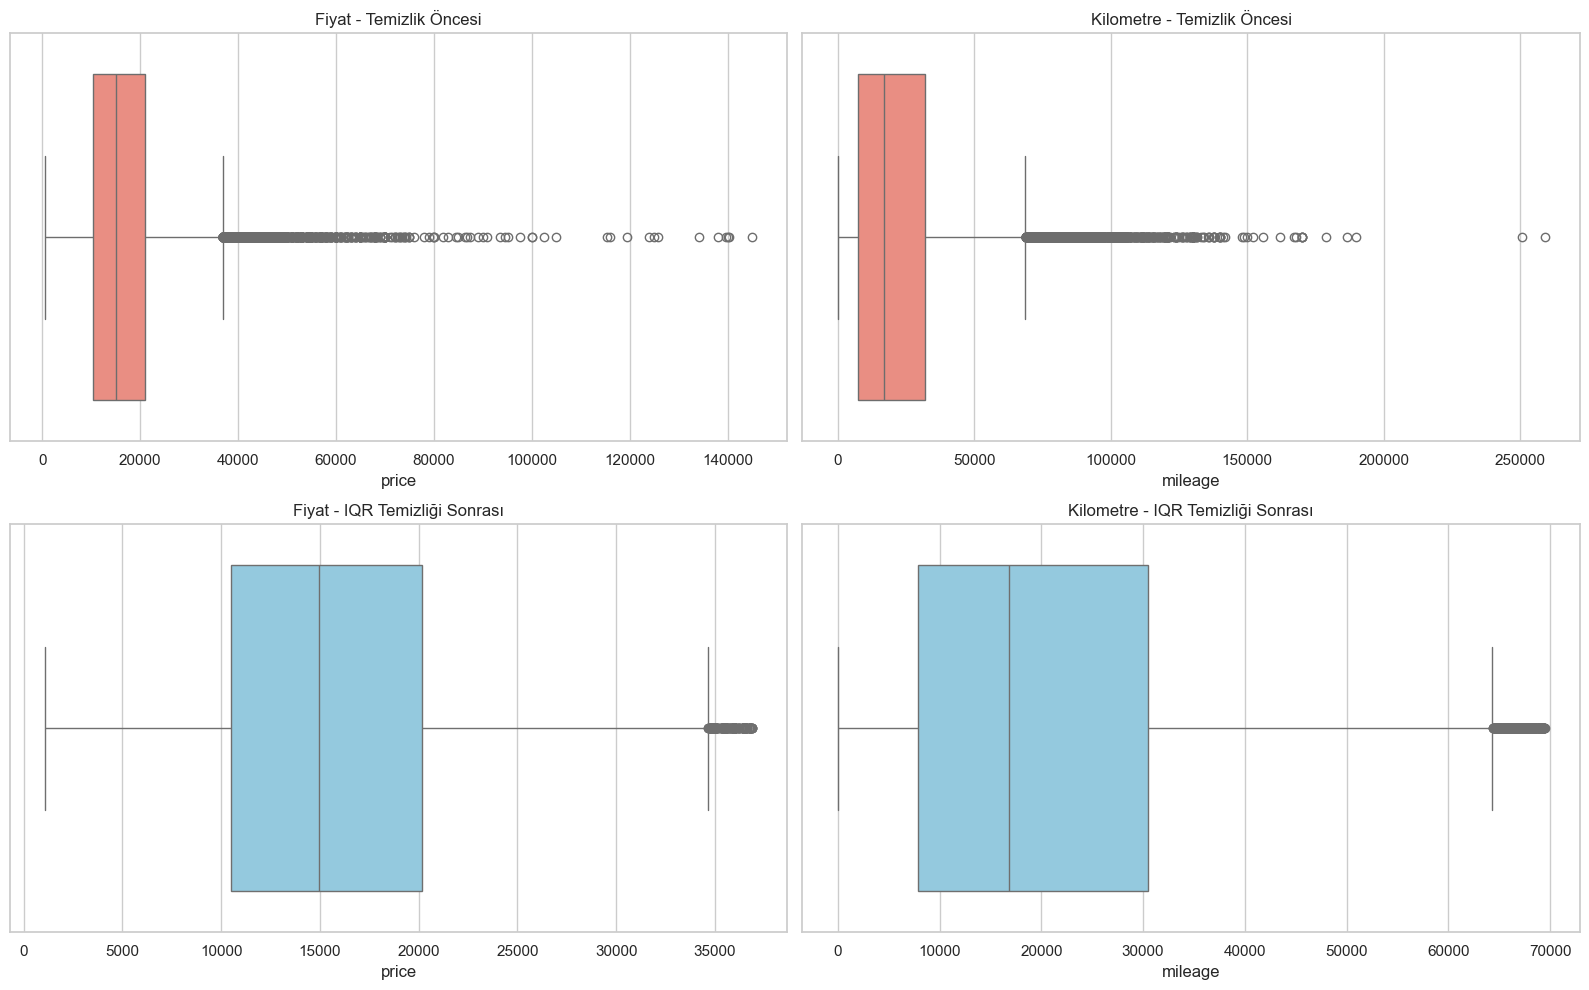

Aykırı değer temizliği sonrası veri boyutu: (26973, 11)


In [87]:
# kutu grafikleri (Boxplot) ile veri setindeki uç değerleri tespit edip ve IQR yöntemiyle temizliyorum

def remove_outliers(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]

# temizlik öncesi ve sonrası görselleştirme yapıyorum
fig, ax = plt.subplots(2, 2, figsize=(16, 10))

sns.boxplot(x=df_clean['price'], ax=ax[0,0], color='salmon').set_title('Fiyat - Temizlik Öncesi')
sns.boxplot(x=df_clean['mileage'], ax=ax[0,1], color='salmon').set_title('Kilometre - Temizlik Öncesi')

# temizlik işlemi
df_final = remove_outliers(df_clean, 'price')
df_final = remove_outliers(df_final, 'mileage')

sns.boxplot(x=df_final['price'], ax=ax[1,0], color='skyblue').set_title('Fiyat - IQR Temizliği Sonrası')
sns.boxplot(x=df_final['mileage'], ax=ax[1,1], color='skyblue').set_title('Kilometre - IQR Temizliği Sonrası')

plt.tight_layout()
plt.show()

print(f"Aykırı değer temizliği sonrası veri boyutu: {df_final.shape}")

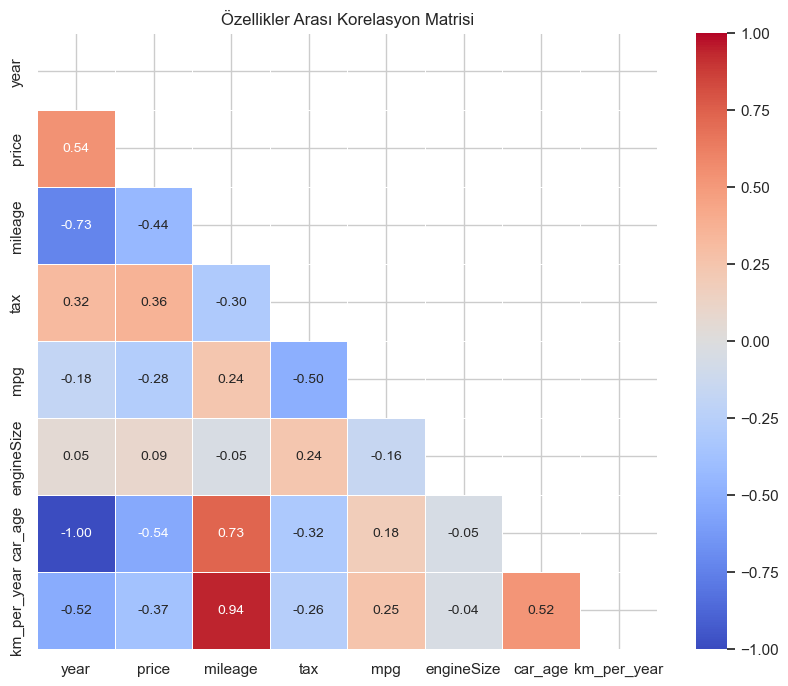

In [88]:
# hangi sayısal özelliklerin fiyat üzerinde daha etkili olduğunu görmek için korelasyon matrisi çiziyorum

plt.figure(figsize=(10, 8))
numeric_df = df_final.select_dtypes(include=['float64', 'int64'])
corr = numeric_df.corr()

# maske oluşturuyorum (simetrik tekrarı önlemek için)
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, vmin=-1, vmax=1)
plt.title('Özellikler Arası Korelasyon Matrisi')
plt.show()

In [89]:
# MODEL HAZIRLIĞI VE PIPELINE KURULUMU

# hedef ve özelliklerin ayrılması
X = df_final.drop(['price', 'year'], axis=1) # Year yerine car_age kullanıyoruz
y = df_final['price']

# train / test split (%80 eğitim, %20 test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# pipeline bileşenleri
numerical_cols = ['car_age', 'mileage', 'km_per_year', 'tax', 'mpg', 'engineSize']
categorical_cols = ['model', 'transmission', 'fuelType']

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

print("Pipeline hazırlandı. Eğitim ve Test setleri ayrıldı.")

Pipeline hazırlandı. Eğitim ve Test setleri ayrıldı.


In [90]:
# FEATURE SELECTION (ÖZELLİK SEÇİMİ)
# Model: ElasticNet (L1 ve L2 Regularization birleşimi)
# Yöntem: SelectKBest kullanarak en etkili özellikleri seçeceğim.

results_df = [] # Sonuçları saklamak için

def run_model_with_selection(k_features, desc):
    # pipeline oluşturma
    # adımlar: ön işleme -> özellik seçimi -> model
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('selector', SelectKBest(score_func=f_regression, k=k_features)),
        ('regressor', ElasticNet(alpha=0.001, l1_ratio=0.7, random_state=42))
    ])
    
    # hedef değişkeni logaritmik dönüştüren regressor (fiyat dağılımını düzeltmek için)
    ttr = TransformedTargetRegressor(regressor=model_pipeline, func=np.log1p, inverse_func=np.expm1)
    
    # eğitim
    ttr.fit(X_train, y_train)
    y_pred = ttr.predict(X_test)
    
    # metrikler
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    results_df.append({
        'Yaklaşım': desc,
        'R2 Score': r2,
        'MAE': mae,
        'RMSE': rmse
    })
    return y_pred

# 1. tüm özellikler
preds_all = run_model_with_selection(k_features='all', desc='ElasticNet (Tüm Özellikler)')

# 2. en iyi 30 özellik (feature selection)
preds_select = run_model_with_selection(k_features=30, desc='ElasticNet (SelectKBest=30)')

print("Modeller eğitildi.")

Modeller eğitildi.


In [91]:
# DIMENSIONALITY REDUCTION (BOYUT İNDİRGEME)
# Model: SGD Regressor (Büyük veri setleri için hızlı optimizasyon)
# Yöntem: TruncatedSVD (PCA benzeri) ile seyrek matrisleri sıkıştırma.

def run_model_with_reduction(n_components, desc):
    # pipeline: ön işleme -> SVD (boyut indirgeme) -> model
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('reduction', TruncatedSVD(n_components=n_components, random_state=42)),
        ('regressor', SGDRegressor(max_iter=3000, penalty='elasticnet', alpha=0.0001, random_state=42))
    ])
    
    ttr = TransformedTargetRegressor(regressor=model_pipeline, func=np.log1p, inverse_func=np.expm1)
    
    ttr.fit(X_train, y_train)
    y_pred = ttr.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    results_df.append({
        'Yaklaşım': desc,
        'R2 Score': r2,
        'MAE': mae,
        'RMSE': rmse
    })

# 3. SVD ile 40 bileşene indirgeme
run_model_with_reduction(n_components=40, desc='SGD Regressor (SVD=40)')

print("Boyut indirgeme modeli eğitildi.")

Boyut indirgeme modeli eğitildi.


,Yaklaşım,R2 Score,MAE,RMSE
0,ElasticNet (Tüm Özellikler),0.814637,2154.898128,3066.274092
1,ElasticNet (SelectKBest=30),0.765604,2469.012766,3448.054705
2,SGD Regressor (SVD=40),0.518220,3104.145595,4943.374673


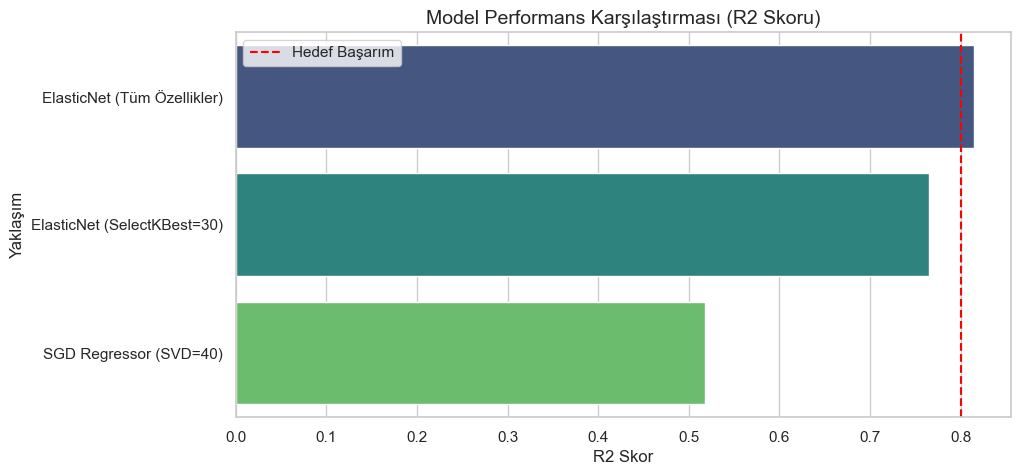

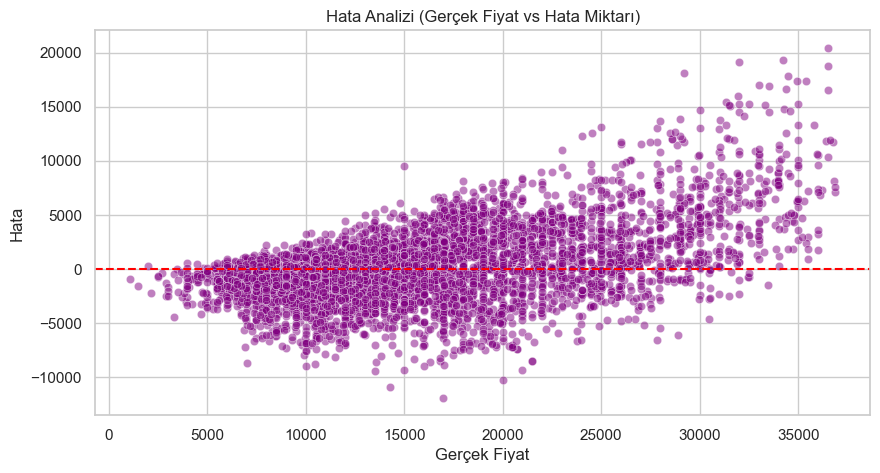

In [94]:
# sonuçların karşılaştırılması ve analiz edilmesi

results = pd.DataFrame(results_df)

# tablo gösterimi
display(results.style.background_gradient(cmap='Greens', subset=['R2 Score']))

# grafik gösterimi
plt.figure(figsize=(10, 5))
ax = sns.barplot(x='R2 Score', y='Yaklaşım', data=results, palette='viridis')
plt.title('Model Performans Karşılaştırması (R2 Skoru)', fontsize=14)
plt.xlabel('R2 Skor')
plt.axvline(0.8, color='red', linestyle='--', label='Hedef Başarım') # Hedef çizgisi
plt.legend()
plt.show()

# hata analizi
plt.figure(figsize=(10, 5))
residuals = y_test - preds_select # En iyi performans genelde Selection'da olur
sns.scatterplot(x=y_test, y=residuals, alpha=0.5, color='purple')
plt.axhline(0, color='red', linestyle='--')
plt.title('Hata Analizi (Gerçek Fiyat vs Hata Miktarı)')
plt.xlabel('Gerçek Fiyat')
plt.ylabel('Hata')
plt.show()

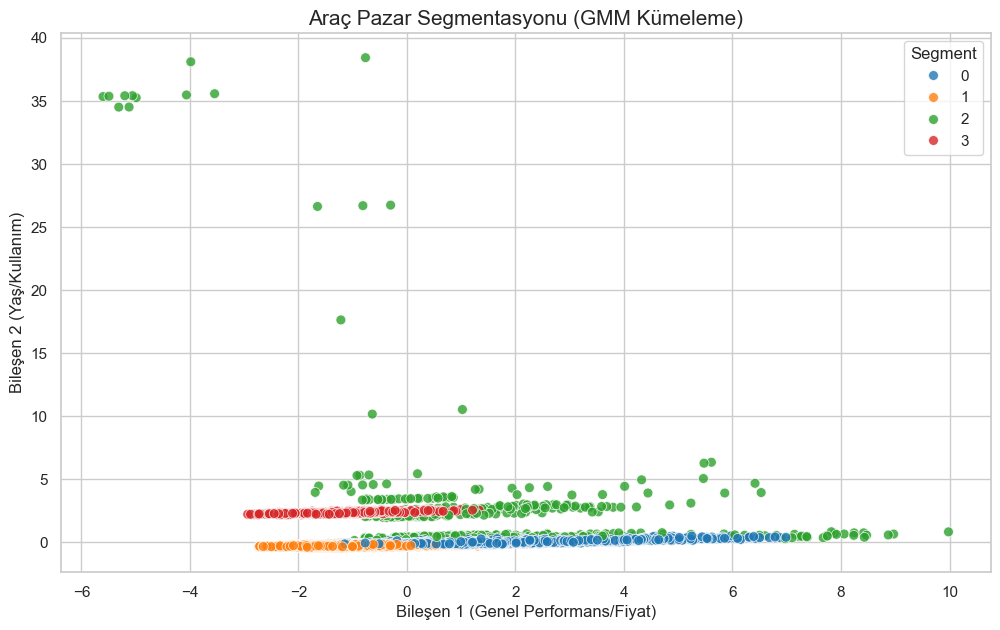

In [93]:
# KÜMELEME ANALİZİ
# amaç: araçları fiyat ve performans özelliklerine göre doğal gruplara (segmentlere) ayırmak.
# model: gaussian Mixture Model (GMM)

# kümeleme için veri hazırlığı (sadece sayısal veriler ve log_price)
cluster_data = df_final[['price', 'mileage', 'car_age', 'engineSize']].copy()
cluster_data['log_price'] = np.log1p(cluster_data['price'])
cluster_data.drop('price', axis=1, inplace=True)

# ölçeklendirme
scaler_cl = StandardScaler()
X_cl_scaled = scaler_cl.fit_transform(cluster_data)

# boyut indirgeme (görselleştirme için 2D'ye indirme)
svd_cl = TruncatedSVD(n_components=2, random_state=42)
X_cl_svd = svd_cl.fit_transform(X_cl_scaled)

# GMM modelleme (4 segment arayışı)
gmm = GaussianMixture(n_components=4, random_state=42)
labels = gmm.fit_predict(X_cl_svd)

# sonuçları görselleştirme
plt.figure(figsize=(12, 7))
sns.scatterplot(x=X_cl_svd[:, 0], y=X_cl_svd[:, 1], hue=labels, palette='tab10', s=50, alpha=0.8)
plt.title('Araç Pazar Segmentasyonu (GMM Kümeleme)', fontsize=15)
plt.xlabel('Bileşen 1 (Genel Performans/Fiyat)')
plt.ylabel('Bileşen 2 (Yaş/Kullanım)')
plt.legend(title='Segment')
plt.show()